# Finetune a stable diffusion model for text to image generation

Using Amazon [SageMaker JumpStart](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)

In [1]:
import os
import sagemaker, boto3, json
from sagemaker import get_execution_role
from dotenv import load_dotenv

load_dotenv()

#get execution role if within sagemaker or get it from the environment
try:
    aws_role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    SAGEMAKER_EXECUTION_ROLE = os.getenv("SAGEMAKER_EXECUTION_ROLE")
    aws_role = iam.get_role(RoleName=SAGEMAKER_EXECUTION_ROLE)['Role']['Arn']

aws_region = boto3.Session().region_name
sess = sagemaker.Session()
print(aws_region)
print (sess.default_bucket())

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/dpradilla/Library/Application Support/sagemaker/config.yaml


Couldn't call 'get_role' to get Role ARN from role name depr001 to get Role path.


eu-central-1
sagemaker-eu-central-1-510357808667


## Fine tune on a custom dataset

The model can be fine-tuned to any dataset of images. It works very well even with as little as five training images.

The fine-tuning script is built on the script from [dreambooth](https://dreambooth.github.io/). The model returned by fine-tuning can be further deployed for inference. Below are the instructions for how the training data should be formatted.

- **Input:** A directory containing the instance images, `dataset_info.json` and (optional) directory `class_data_dir`.
  - Images may be of `.png` or `.jpg` or `.jpeg` format.
  - `dataset_info.json` file must be of the format {'instance_prompt':<<instance_prompt>>,'class_prompt':<<class_prompt>>}.
  - If with_prior_preservation = False, you may choose to ignore 'class_prompt'.
  - `class_data_dir` directory must have class images. If with_prior_preservation = True and class_data_dir is not present or there are not enough images already present in class_data_dir, additional images will be sampled with class_prompt.
- **Output:** A trained model that can be deployed for inference.

The s3 path should look like `s3://bucket_name/input_directory/`. Note the trailing `/` is required.

Here is an example format of the training data.

    input_directory
        |---instance_image_1.png
        |---instance_image_2.png
        |---instance_image_3.png
        |---instance_image_4.png
        |---instance_image_5.png
        |---dataset_info.json
        |---class_data_dir
            |---class_image_1.png
            |---class_image_2.png
            |---class_image_3.png
            |---class_image_4.png

**Prior preservation, instance prompt and class prompt:** Prior preservation is a technique that uses additional images of the same class that we are trying to train on.  For instance, if the training data consists of images of a particular dog, with prior preservation, we incorporate class images of generic dogs. It tries to avoid overfitting by showing images of different dogs while training for a particular dog. Tag indicating the specific dog present in instance prompt is missing in the class prompt. For instance, instance prompt may be "a photo of a Doppler dog" and class prompt may be "a photo of a dog". You can enable prior preservation by setting the hyper-parameter with_prior_preservation = True.

### Retrieve Training Artifacts

---
Here, we retrieve the training docker container, the training algorithm source, and the pre-trained base model. Note that model_version="*" fetches the latest model.

---

In [2]:
from sagemaker import image_uris, model_uris, script_uris

# Currently, not all the stable diffusion models in jumpstart support finetuning. Thus, we manually select a model
# which supports finetuning.
train_model_id, train_model_version, train_scope = (
    "model-txt2img-stabilityai-stable-diffusion-v2-1-base",
    "*",
    "training",
)

# Tested with ml.p3.2xlarge (),ml.g4dn.2xlarge (16GB GPU memory),and ml.g5.2xlarge (24GB GPU memory) instances. Other instances may work as well.
# If ml.g5.2xlarge instance type is available, please change the following instance type to speed up training. Note: If using Workshop Studio accounts,
# leave the default instance below.
training_instance_type = "ml.g5.2xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)

# Retrieve the training script. This contains all the necessary files including data processing, model training etc.
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

Using model 'model-txt2img-stabilityai-stable-diffusion-v2-1-base' with wildcard version identifier '*'. You can pin to version '2.0.0' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


In [3]:
# Sample training data is available in this bucket
training_data_bucket = sess.default_bucket()
training_data_prefix = "sagemaker-jumpstart-sd-finetuning/data/dogs_sd_finetuning/"

training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}"

output_bucket = sess.default_bucket()
output_prefix = "sagemaker-jumpstart-sd-finetuning/training"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

In [4]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters["max_steps"] = "400"
hyperparameters["with_prior_preservation"] = True
print(hyperparameters)

{'epochs': '20', 'max_steps': '400', 'batch_size': '1', 'with_prior_preservation': True, 'num_class_images': '100', 'learning_rate': '2e-06', 'prior_loss_weight': '1.0', 'center_crop': 'False', 'lr_scheduler': 'constant', 'adam_weight_decay': '0.01', 'adam_beta1': '0.9', 'adam_beta2': '0.999', 'adam_epsilon': '1e-08', 'gradient_accumulation_steps': '1', 'max_grad_norm': '1.0', 'compute_fid': 'False', 'seed': '0'}


### Start Training

Create estimator and launch the training job

In [5]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base
from sagemaker.tuner import HyperparameterTuner

training_job_name = name_from_base(f"jumpstart-example-{train_model_id}-transfer-learning")

# Create SageMaker Estimator instance
sd_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",  # Entry-point file in source_dir and present in train_source_uri.
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
    base_job_name=training_job_name,
)


In [ ]:

# Launch a SageMaker Training job by passing s3 path of the training data
sd_estimator.fit({"training": training_dataset_s3_path}, logs=True)


In [6]:
#load previously trained job
sd_estimator = sagemaker.estimator.Estimator.attach('jumpstart-example-model-txt2img-stabili-2024-05-03-22-19-12-271')



2024-05-03 22:37:50 Starting - Starting the training job
2024-05-03 22:37:50 Pending - Preparing the instances for training
2024-05-03 22:37:50 Downloading - Downloading the training image
2024-05-03 22:37:50 Training - Training image download completed. Training in progress.
2024-05-03 22:37:50 Uploading - Uploading generated training model
2024-05-03 22:37:50 Completed - Training job completed


In [8]:
inference_instance_type = "ml.g5.2xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri. This includes scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"jumpstart-example-FT-{train_model_id}-")
print(endpoint_name)

# Use the estimator from the previous step to deploy to a SageMaker endpoint
finetuned_predictor = sd_estimator.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)

jumpstart-example-FT-model-txt2img-stab-2024-05-04-00-08-12-870
--------!

## Query the finetuned model

In [9]:
import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = text.encode("utf-8")

    query_response = model_predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_image"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display hallucinated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

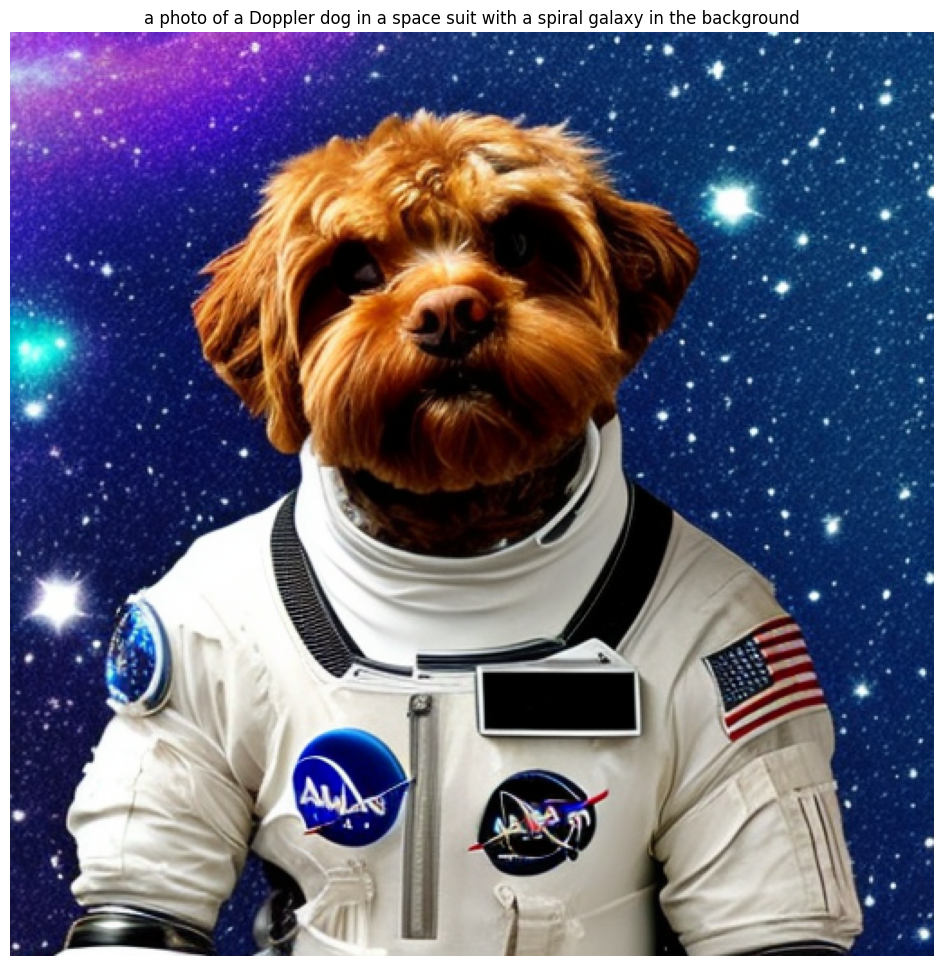

In [18]:
text = "a photo of a Doppler dog in a space suit with a spiral galaxy in the background"
query_response = query(finetuned_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

### Clean up

In [19]:
# Delete the SageMaker endpoint
finetuned_predictor.delete_model()
finetuned_predictor.delete_endpoint()